In [1]:
import os
import json
import pickle
import random
import requests
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
from PIL import Image
from typing import Dict
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import pytorchvideo.transforms as video_transform
import torchvision.transforms._transforms_video as transform_video
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (CenterCropVideo,
                                                      NormalizeVideo)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (ApplyTransformToKey,
                                     ShortSideScale,
                                     UniformTemporalSubsample,
                                     UniformCropVideo)

/home/cmenghini/taglets-video/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:5: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  warnings.warn(
/home/cmenghini/taglets-video/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  warnings.warn(


## Data transformation according to PytorchVideo tutorial

In [2]:
class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // self.alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list
    
def transform_image(train=True, video=False):
    """
    Get the transform to be used on an image.
    :return: A transform
    """
    data_mean = [0.485, 0.456, 0.406]
    data_std = [0.229, 0.224, 0.225]
    # Remember to check it for video and eval
    if video:
        return transforms.Compose([transforms.ToTensor()])

    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=data_mean, std=data_std)
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=data_mean, std=data_std)
        ])

def transformer_video():   
    """Trasformation valid for SlowFast"""
    side_size = 256
    mean = [0.45, 0.45, 0.45]
    std = [0.225, 0.225, 0.225]
    crop_size = 256
    num_frames = 32
    alpha = 4
    

    return  video_transform.ApplyTransformToKey(key="video",
                                transform=transforms.Compose([
                                    video_transform.UniformTemporalSubsample(num_frames),
                                    transforms.Lambda(lambda x: x/255.0),
                                    transform_video.NormalizeVideo(mean, std),# transform_video
                                    video_transform.ShortSideScale(size=side_size),
                                    transform_video.CenterCropVideo(crop_size),# transform_video
                                    PackPathway(alpha)
                                ])
                                )

In [73]:
class CustomVideoDataset(Dataset):
    """
        A custom dataset used to create dataloaders.
        """
    
    def __init__(self, filepaths, labels=None, label_map=None, 
                transform_img=None, transform_vid=None, clips_dictionary=None):
        """
        Create a new CustomVideoDataset.

        :param filepaths: A list of filepaths.
        :param labels: A list of labels
        :param label_map: A dictionary to map string labels to intergers
        :param transform: A transform to perform on the frames
        :pram clips_dictionary: dictionary (id clip, list images) to get frames of a clip
        """
        self.filepaths = filepaths
        self.labels = labels
        self.label_map = label_map
        self.transform_img = transform_img
        self.transform_vid = transform_vid
        self.clips_dictionary = clips_dictionary
    
    def __getitem__(self, index):
        clip_id = int(os.path.basename(self.filepaths[index]))  # chech what path you have/want
        frames_paths = self.clips_dictionary[str(clip_id)]

        frames = []
        for f in frames_paths:#frames_paths[:num_frames]:#[:10]:  # get same size clips - random pick for eval
            frame = Image.open(f).convert('RGB')
            #if self.transform is not None:  # BE CAREFUL TRANSFORMATION MIGHT NEED TO CHANGE FOR VIDEO EVAL!!!!!
            frame = self.transform_img(frame)
            frames.append(frame)
        
        img = torch.stack(frames)  # need to be of the same size!
        img = torch.transpose(img, 0, 1) 
        video_data = {'video': img}
        img = self.transform_vid(video_data)
        
        if self.labels is not None:
            if self.label_map is not None:
                label = torch.tensor(self.label_map[(self.labels[index])])
                
            else:
                label = torch.tensor(int(self.labels[index]))
            return img, label, clip_id
        else:
            return img
    
    def __len__(self):
        return len(self.filepaths)


## Use the API to get same data as JPL to train

In [74]:
def create_session(task_name):
    """
    Create a new session.
    :param task_name: The name of the task (problem
    :return: None
    """
    headers = {'user_secret': team_secret,
               'govteam_secret': ''}
    session_json = {'session_name': 'testing', 'data_type': data_type, 'task_id': task_name}

    response = post_only_once("auth/create_session", headers, session_json)

    session_token = response['session_token']
    session_token = session_token
    return session_token

def post_only_once(command, headers, posting_json):
    r = requests.post(url + "/" + command,
                      json=posting_json, 
                      headers=headers)
    return r.json()

def get_only_once(command, headers):
        
        r = requests.get(url + "/" + command, 
                         headers=headers)
        return r.json()
    
def get_session_status():
    """
    Get the session status.
    :return: The session status
    """
    headers = {'user_secret': team_secret,
               'govteam_secret': '',
               'session_token': session_token}
    r = requests.get(url + "/session_status", headers=headers)
    if 'Session_Status' in r.json():
        return r.json()['Session_Status']
    else:
        return {}

In [75]:
url = 'https://api-dev.lollllz.com/'
team_secret = 'a5aed2a8-db80-4b22-bf72-11f2d0765572'
data_type = 'full'
task_name = '9c103cc4-e2e1-4070-9877-c3b64a6f327f'
session_token = create_session(task_name)


# I ran the code on the VM, that's why the path has mnt/
dataset_dir = '/mnt/lwll/datasets/external'
dataset_name = 'hmdb'
data_type = 'full'

evaluation_meta_path = os.path.join(dataset_dir,
                                    dataset_name,
                                    "labels" + "_" + data_type,
                                    "meta_test.feather")
evaluation_image_path = os.path.join(dataset_dir,
                                     dataset_name,
                                     dataset_name + "_" + data_type,
                                     "test")

unlabeled_image_path = os.path.join(dataset_dir,
                                     dataset_name,
                                     dataset_name + "_" + data_type,
                                     "train")

test_labels_path = os.path.join(dataset_dir,
                              '..',
                              'external',
                              dataset_name,
                              "labels" + "_" + data_type,
                              "labels_test.feather")

all_train_labels_path = os.path.join(dataset_dir,
                                    '..',
                                    'external',
                                    dataset_name,
                                    "labels" + "_" + data_type,
                                    "labels_train.feather")

In [76]:
headers = {'user_secret': team_secret,
               'govteam_secret': '',
               'session_token': session_token}
#log.debug(f"HEADERS: {headers}")
response = get_only_once("seed_labels", headers)
labels = response['Labels']

In [77]:
# Ceate class mapping
session_status = get_session_status()
current_dataset = session_status['current_dataset']

classes = current_dataset['classes']

label_map = {}
class_names = classes
for idx, item in enumerate(class_names):
    label_map[item] = idx

In [78]:
label_map

{'turn': 0,
 'swing_baseball': 1,
 'eat': 2,
 'somersault': 3,
 'situp': 4,
 'shoot_bow': 5,
 'kiss': 6,
 'draw_sword': 7,
 'sit': 8,
 'golf': 9,
 'pushup': 10,
 'shoot_ball': 11,
 'pullup': 12,
 'stand': 13,
 'jump': 14,
 'fencing': 15,
 'smoke': 16,
 'push': 17,
 'cartwheel': 18,
 'flic_flac': 19,
 'hit': 20,
 'run': 21,
 'ride_horse': 22,
 'catch': 23,
 'sword_exercise': 24,
 'walk': 25,
 'talk': 26,
 'fall_floor': 27,
 'climb_stairs': 28,
 'climb': 29,
 'brush_hair': 30,
 'pick': 31,
 'punch': 32,
 'chew': 33,
 'throw': 34,
 'clap': 35,
 'dribble': 36,
 'drink': 37,
 'sword': 38,
 'kick_ball': 39,
 'pour': 40,
 'dive': 41,
 'shake_hands': 42,
 'ride_bike': 43,
 'smile': 44,
 'shoot_gun': 45,
 'laugh': 46,
 'wave': 47,
 'handstand': 48,
 'kick': 49,
 'hug': 50}

In [79]:
# Training data
labeled_images = []
dictionary_clips = {}
for clip in labels:
    action_frames = [str(clip['id']) + '/' + str(i)+'.jpg' for i in range(clip['start_frame'], clip['end_frame'] + 1)]
    dictionary_clips[clip["id"]] = action_frames
    labeled_images.append([clip["class"], clip["id"]])

In [80]:
dictionary_clips['881'][:10]

['881/80326.jpg',
 '881/80327.jpg',
 '881/80328.jpg',
 '881/80329.jpg',
 '881/80330.jpg',
 '881/80331.jpg',
 '881/80332.jpg',
 '881/80333.jpg',
 '881/80334.jpg',
 '881/80335.jpg']

In [81]:
labeled_images[:10]

[['brush_hair', '881'],
 ['cartwheel', '1366'],
 ['catch', '93'],
 ['chew', '561'],
 ['clap', '294'],
 ['climb', '679'],
 ['climb_stairs', '1064'],
 ['dive', '1428'],
 ['draw_sword', '360'],
 ['dribble', '145']]

In [82]:
image_labels, image_names = list(zip(*labeled_images))
image_paths = [os.path.join(unlabeled_image_path, str(image_name)) for image_name in image_names]

In [83]:
paths_dictionary_clips = {}
for clip, frames in dictionary_clips.items():
    paths_dictionary_clips[clip] = [os.path.join(unlabeled_image_path, str(f)) for f in frames]
dictionary_clips = paths_dictionary_clips

In [85]:
img = Image.open('/mnt/lwll/datasets/external/hmdb/hmdb_full/train/881/80444.jpg')

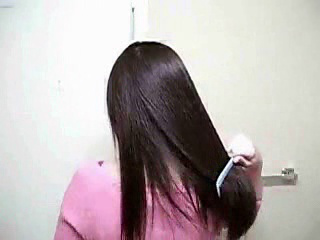

In [86]:
img

In [87]:
image_paths = np.asarray(image_paths)
image_labels = np.asarray(image_labels)

train_idx = list(range(len(image_paths)))
val_idx = []

In [88]:
labeled_dataset = CustomVideoDataset(image_paths[train_idx], 
                                   labels=image_labels[train_idx],
                                   label_map=label_map,
                                   transform_img=transform_image(video=True),
                                   transform_vid=transformer_video(),
                                   clips_dictionary=dictionary_clips)

if len(val_idx) != 0:
    val_dataset = CustomVideoDataset(image_paths[val_idx],
                                     labels=image_labels[val_idx],
                                     label_map=label_map,
                                     transform_img=transform_image(video=True),
                                     transform_vid=transformer_video(),
                                     clips_dictionary=dictionary_clips)
else:
    val_dataset = None

In [96]:
labeled_dataset.__dict__.keys()

dict_keys(['filepaths', 'labels', 'label_map', 'transform_img', 'transform_vid', 'clips_dictionary'])

In [90]:
image_paths = []
dictionary_clips = {}
test_meta = pd.read_feather(evaluation_meta_path)
for clip in test_meta.iterrows():
    row = clip[1]
    action_frames = [os.path.join(evaluation_image_path, str(row['id'])) + '/' + str(i)+'.jpg'
                     for i in range(row['start_frame'], row['end_frame'])] 
    dictionary_clips[row["id"]] = action_frames
    image_paths.append(os.path.join(evaluation_image_path, str(row["id"])))
    
evaluation_dataset = CustomVideoDataset(image_paths,
                                        transform_img=transform_image(train=False, video=True),
                                        transform_vid=transformer_video(),
                                        clips_dictionary=dictionary_clips)

## Extract features

In [30]:
# Load model
device = "cpu"

# Pick a pretrained model and load the pretrained weights
model_name = "slowfast_r50"
model = torch.hub.load("facebookresearch/pytorchvideo", model=model_name, pretrained=True)

# Set to eval mode and move to desired device
model = model.to(device)

Using cache found in /home/cmenghini/.cache/torch/hub/facebookresearch_pytorchvideo_master


Here I substitute the last layer with the identity such to get the
features. Looking at the code of JPL (which relies on the paper's code
https://gitlab.lollllz.com/bjohnson/lwll_baselines/-/blob/master/video_classification/tools/emb_net.py
in lines 83-88 you can see that other than the projection theey also change act. That should be an activation
function, but I can't find it in the model I downloaded)

In [31]:
model.blocks[6].proj = nn.Sequential()

In [32]:
model = model.eval()

In [91]:
# Extract training features
inference_loader = torch.utils.data.DataLoader(
            dataset=labeled_dataset, batch_size=1, shuffle=False,
            num_workers=0, pin_memory=True)

Label tensor([30]) and frame id tensor([881])


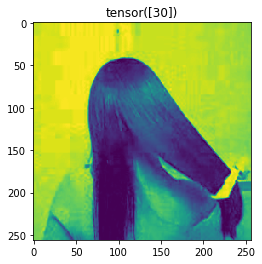

Press [enter] to continue.


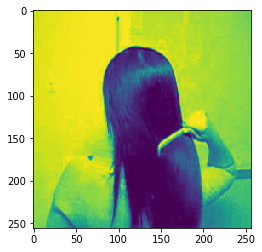

Label tensor([18]) and frame id tensor([1366])


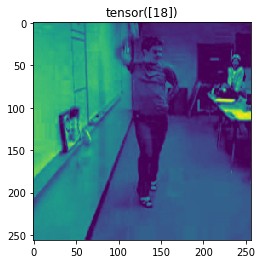

Press [enter] to continue.


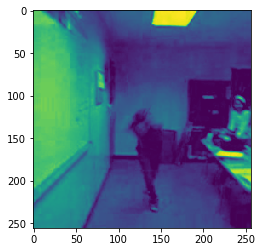

Label tensor([23]) and frame id tensor([93])


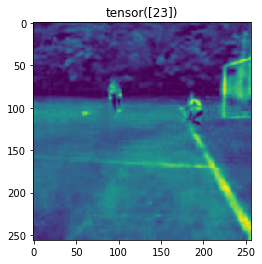

Press [enter] to continue.


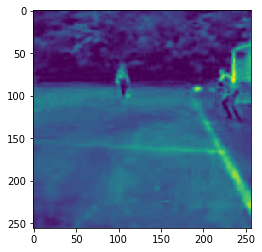

Label tensor([33]) and frame id tensor([561])


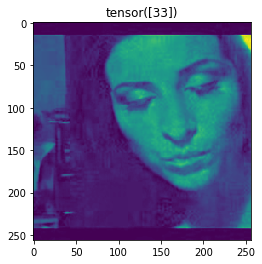

Press [enter] to continue.


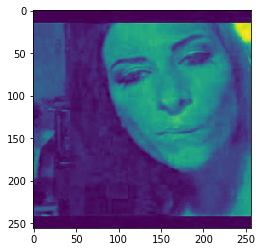

Label tensor([35]) and frame id tensor([294])


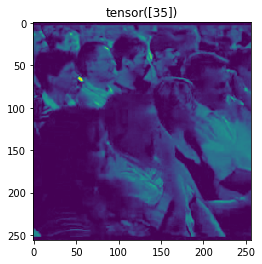

Press [enter] to continue.


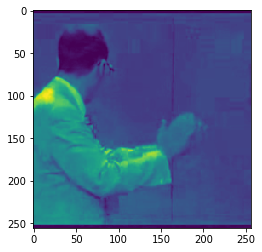

Label tensor([29]) and frame id tensor([679])


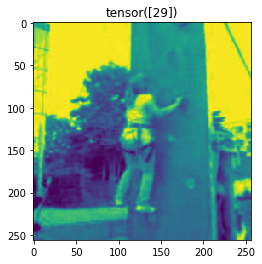

Press [enter] to continue.


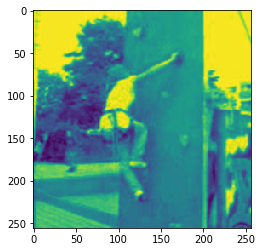

Label tensor([28]) and frame id tensor([1064])


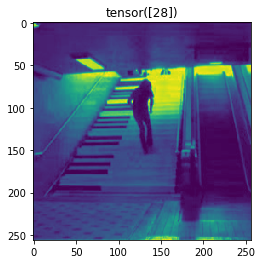

Press [enter] to continue.


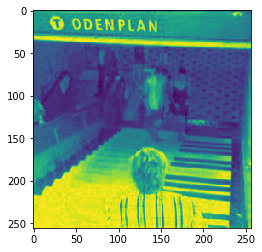

Label tensor([41]) and frame id tensor([1428])


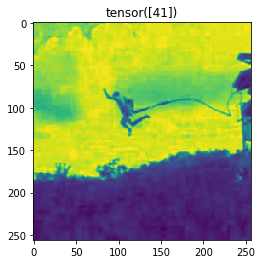

Press [enter] to continue.


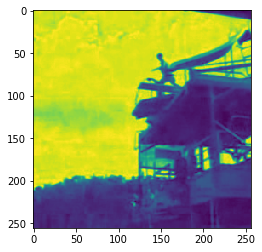

Label tensor([7]) and frame id tensor([360])


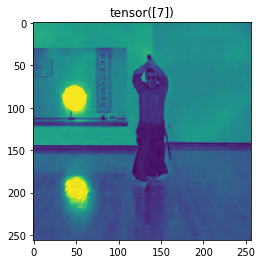

Press [enter] to continue.


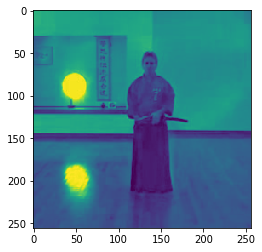

Label tensor([36]) and frame id tensor([145])


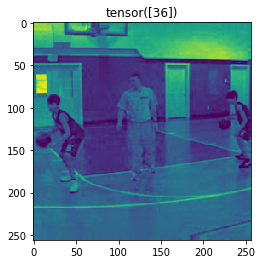

Press [enter] to continue.


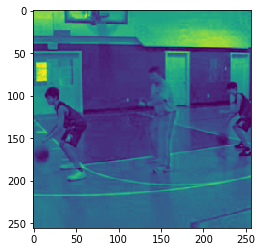

Label tensor([37]) and frame id tensor([209])


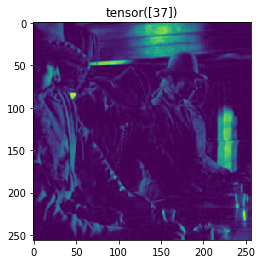

Press [enter] to continue.


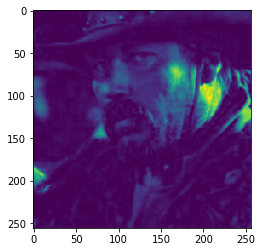

Label tensor([2]) and frame id tensor([1697])


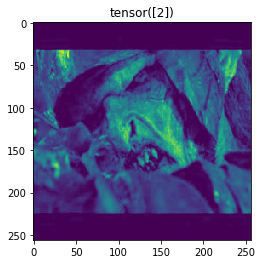

Press [enter] to continue.


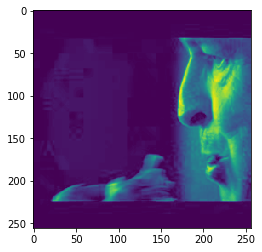

Label tensor([27]) and frame id tensor([110])


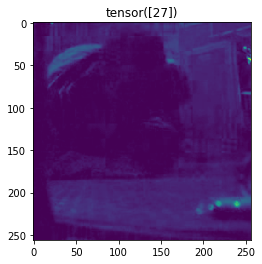

Press [enter] to continue.


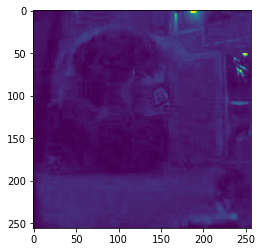

Label tensor([15]) and frame id tensor([1637])


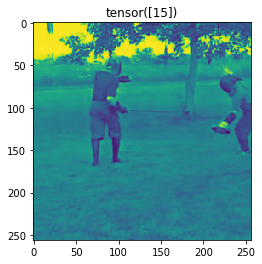

Press [enter] to continue.


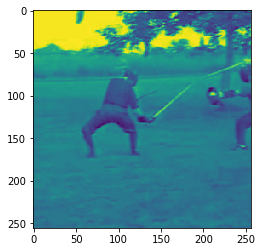

Label tensor([19]) and frame id tensor([1783])


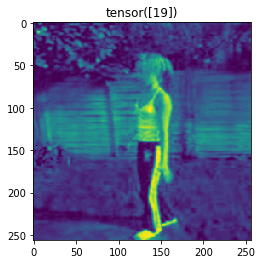

Press [enter] to continue.


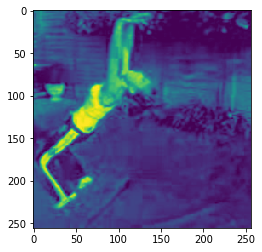

Label tensor([9]) and frame id tensor([893])


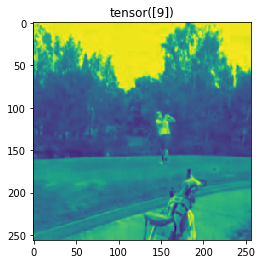

Press [enter] to continue.


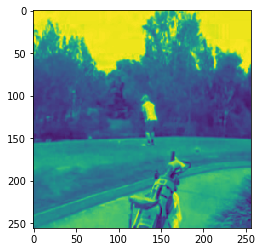

Label tensor([48]) and frame id tensor([1726])


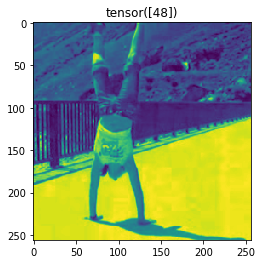

Press [enter] to continue.


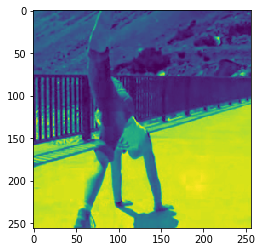

Label tensor([20]) and frame id tensor([1689])


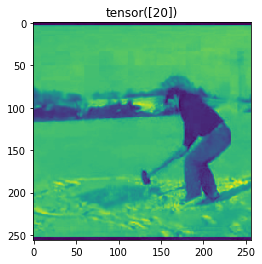

Press [enter] to continue.


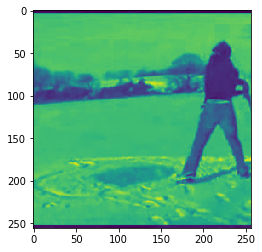

Label tensor([50]) and frame id tensor([1424])


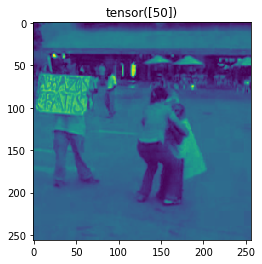

Press [enter] to continue.


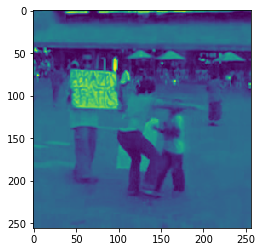

Label tensor([14]) and frame id tensor([46])


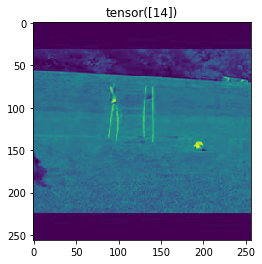

Press [enter] to continue.


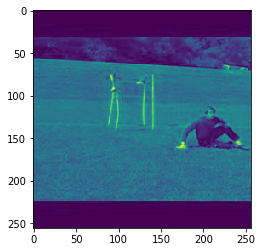

Label tensor([49]) and frame id tensor([1321])


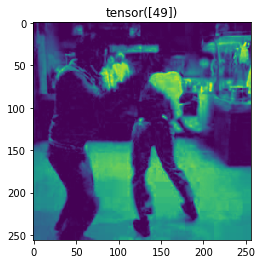

Press [enter] to continue.


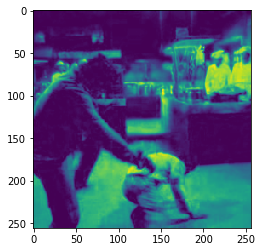

Label tensor([39]) and frame id tensor([1283])


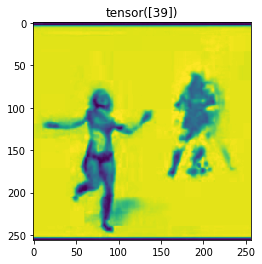

Press [enter] to continue.


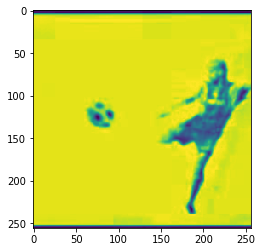

Label tensor([6]) and frame id tensor([564])


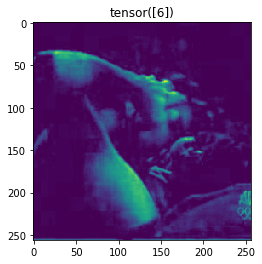

Press [enter] to continue.


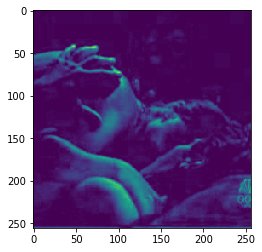

Label tensor([46]) and frame id tensor([2017])


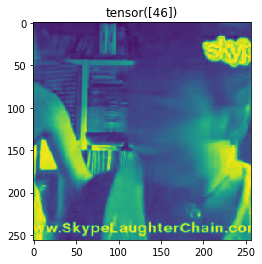

Press [enter] to continue.


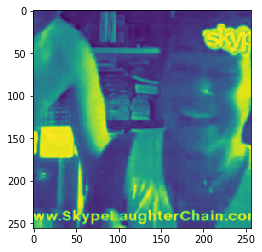

Label tensor([31]) and frame id tensor([581])


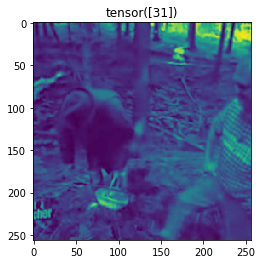

Press [enter] to continue.


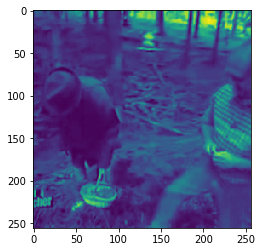

Label tensor([40]) and frame id tensor([818])


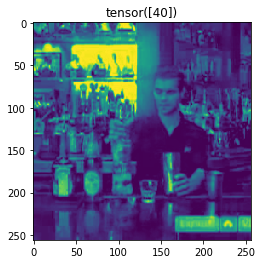

Press [enter] to continue.


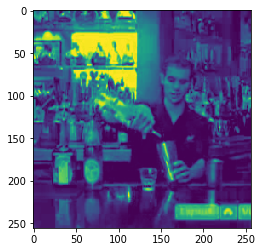

Label tensor([12]) and frame id tensor([443])


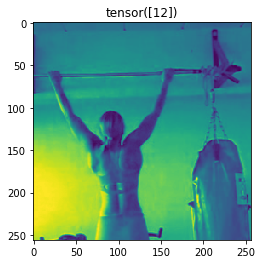

Press [enter] to continue.


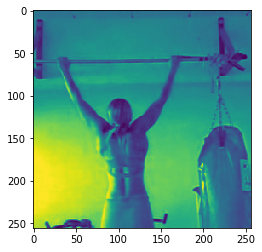

Label tensor([32]) and frame id tensor([259])


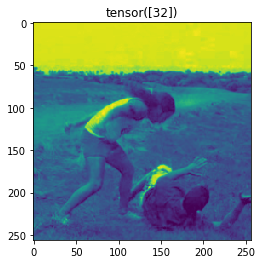

Press [enter] to continue.


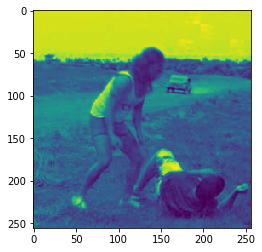

Label tensor([17]) and frame id tensor([1343])


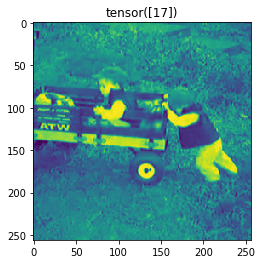

Press [enter] to continue.


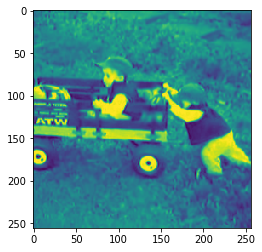

Label tensor([10]) and frame id tensor([1066])


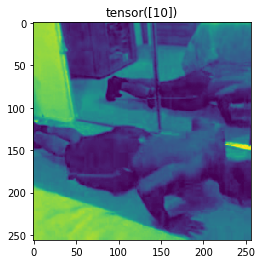

Press [enter] to continue.


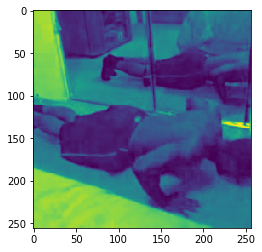

Label tensor([43]) and frame id tensor([540])


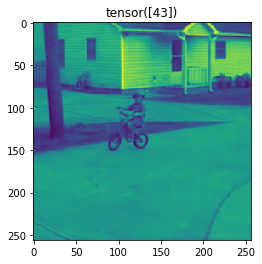

Press [enter] to continue.


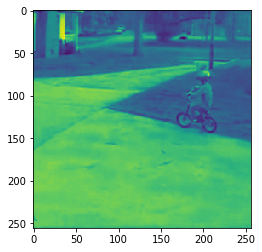

Label tensor([22]) and frame id tensor([1759])


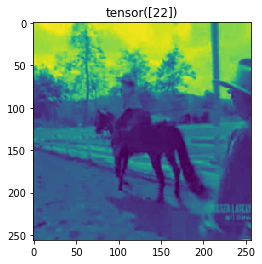

Press [enter] to continue.


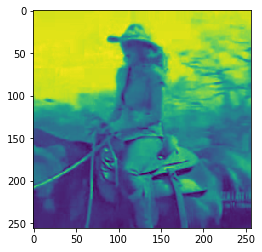

Label tensor([21]) and frame id tensor([142])


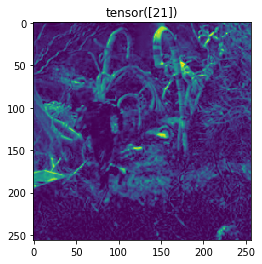

Press [enter] to continue.


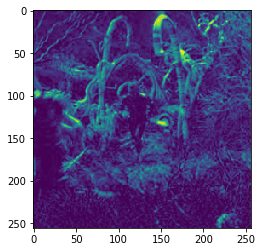

Label tensor([42]) and frame id tensor([287])


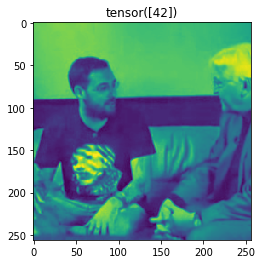

Press [enter] to continue.


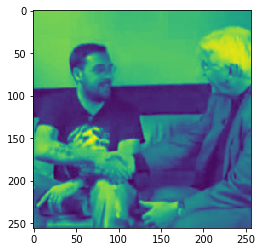

Label tensor([11]) and frame id tensor([1665])


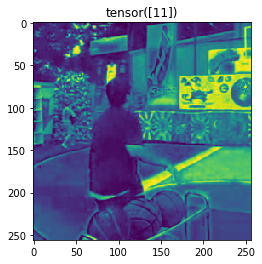

Press [enter] to continue.


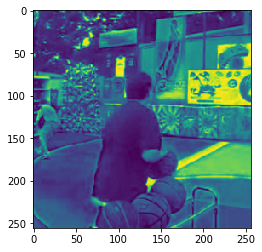

Label tensor([5]) and frame id tensor([1396])


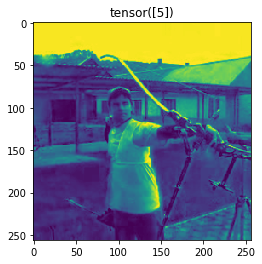

Press [enter] to continue.


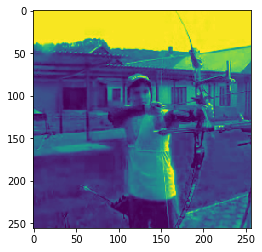

Label tensor([45]) and frame id tensor([983])


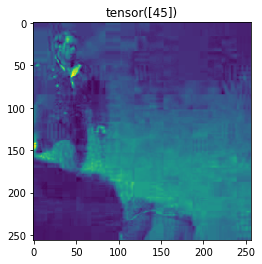

Press [enter] to continue.


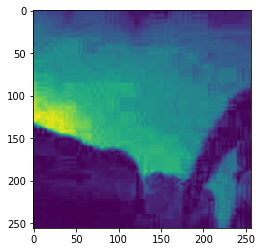

Label tensor([8]) and frame id tensor([198])


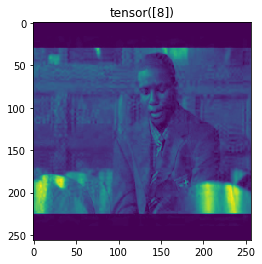

Press [enter] to continue.


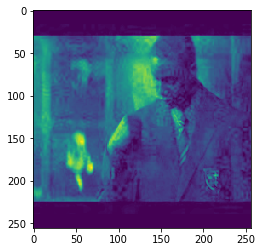

Label tensor([4]) and frame id tensor([750])


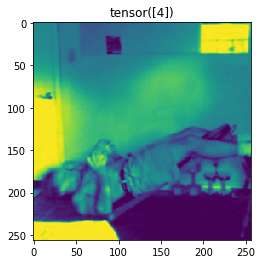

Press [enter] to continue.


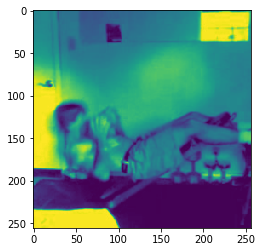

Label tensor([44]) and frame id tensor([542])


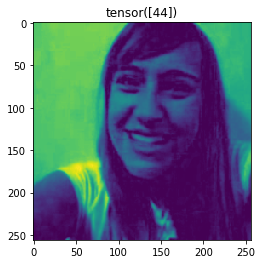

Press [enter] to continue.


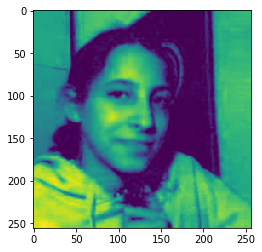

Label tensor([16]) and frame id tensor([647])


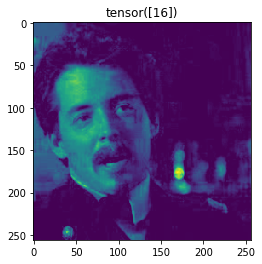

Press [enter] to continue.


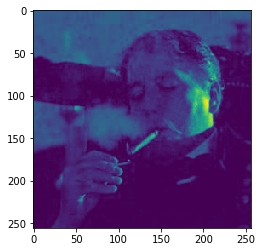

Label tensor([3]) and frame id tensor([89])


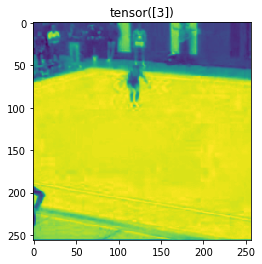

Press [enter] to continue.


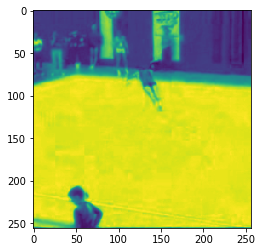

Label tensor([13]) and frame id tensor([1363])


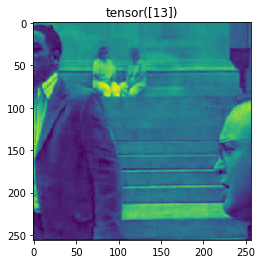

Press [enter] to continue.


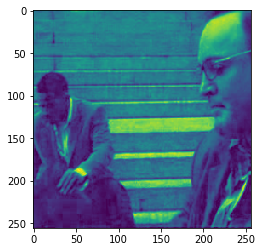

Label tensor([1]) and frame id tensor([103])


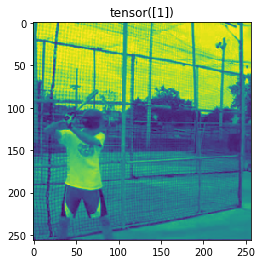

Press [enter] to continue.


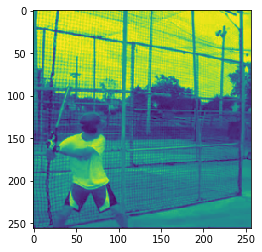

Label tensor([38]) and frame id tensor([2036])


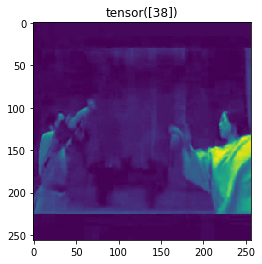

Press [enter] to continue.


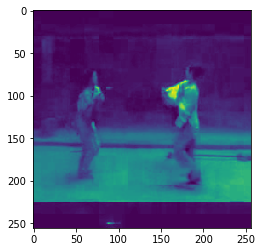

Label tensor([24]) and frame id tensor([1854])


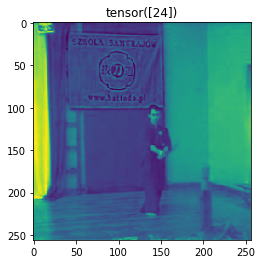

Press [enter] to continue.


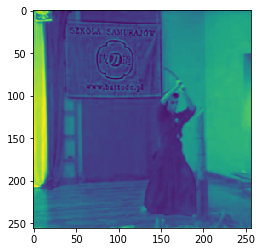

Label tensor([26]) and frame id tensor([716])


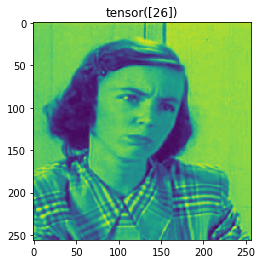

Press [enter] to continue.


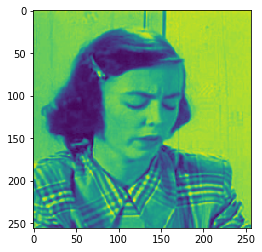

Label tensor([34]) and frame id tensor([484])


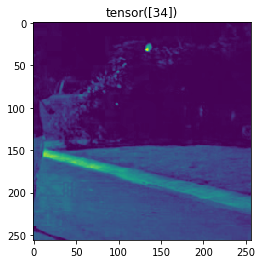

Press [enter] to continue.


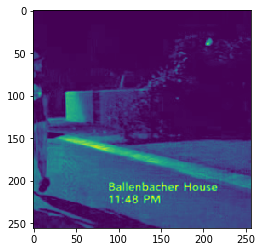

Label tensor([0]) and frame id tensor([216])


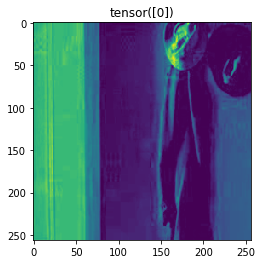

Press [enter] to continue.


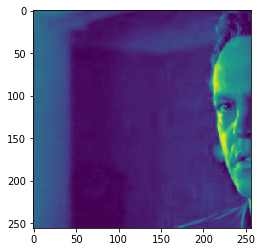

Label tensor([25]) and frame id tensor([118])


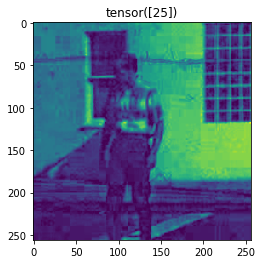

Press [enter] to continue.


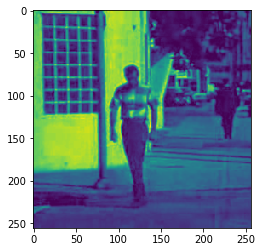

Label tensor([47]) and frame id tensor([370])


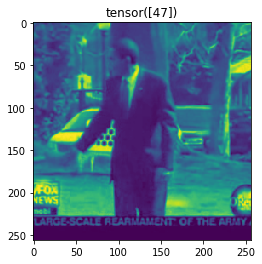

Press [enter] to continue.


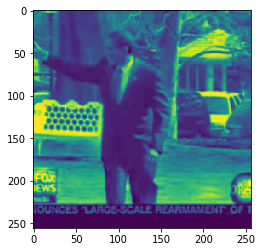

In [112]:
for batch in inference_loader:
    inputs = batch[0]['video']
    print(f"Label {batch[1]} and frame id {batch[2]}" )
    
    plt.title(str(batch[1]))

    plt.imshow(inputs[0][0][2][7])
    plt.show()
    _ = input("Press [enter] to continue.")
    plt.close()
    plt.imshow(inputs[1][0][2][7])
    plt.show()

In [ ]:
# To speed it up we can use the GPUs
X = np.zeros((len(labeled_dataset.filepaths), 2304))
Y = np.zeros((51))
i = 0
for batch in inference_loader:
    inputs = batch[0]['video']
    #print(inputs[0].size())
    labels = batch[1]

    
    output = model(inputs)
    #print(torch.max(output, 1)[1])
    print(labels.item())
    X[i,:] = output.detach().numpy()[0]
    Y[i] = labels.item()
    i += 1
    print(i)

In [ ]:
pickle.dump(X, open("X.p","wb"))
pickle.dump(Y, open("Y.p", "wb"))

In [113]:
#X = pickle.load(open("X.p", "rb" ))
#Y = pickle.load(open("Y.p", "rb" ))

In [115]:
X.shape

(51, 2304)

In [155]:
evaluation_loader = torch.utils.data.DataLoader(
            dataset=evaluation_dataset, batch_size=1, shuffle=False,
            num_workers=0, pin_memory=True)

In [ ]:
# This operation takes long if executed on cpu
eval_X = np.zeros((len(evaluation_dataset.filepaths), 2304))

i = 0
for batch in evaluation_loader:
    inputs = batch['video']
    #print(inputs[0].size())

    output = model(inputs)
    #print(output.detach().numpy()[0])
    eval_X[i,:] = output.detach().numpy()[0]
    i += 1
    print(i)

In [ ]:
pickle.dump(eval_X, open("eval_X.p", "wb"))

In [116]:
#eval_X = pickle.load(open("eval_X.p", "rb" ))

In [135]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(eval_X)
X_embedded.shape

(1354, 2)

In [140]:
eval_X.shape

(1354, 2304)

In [150]:
concat_X = np.concatenate((X, eval_X), axis=0)

X_embedded = TSNE(n_components=2).fit_transform(concat_X)
X_embedded.shape

(1405, 2)

In [180]:
eval_embedding = X_embedded[51:, :]

In [181]:
eval_embedding.shape

(1354, 2)

In [182]:
set_labels = set(labels)

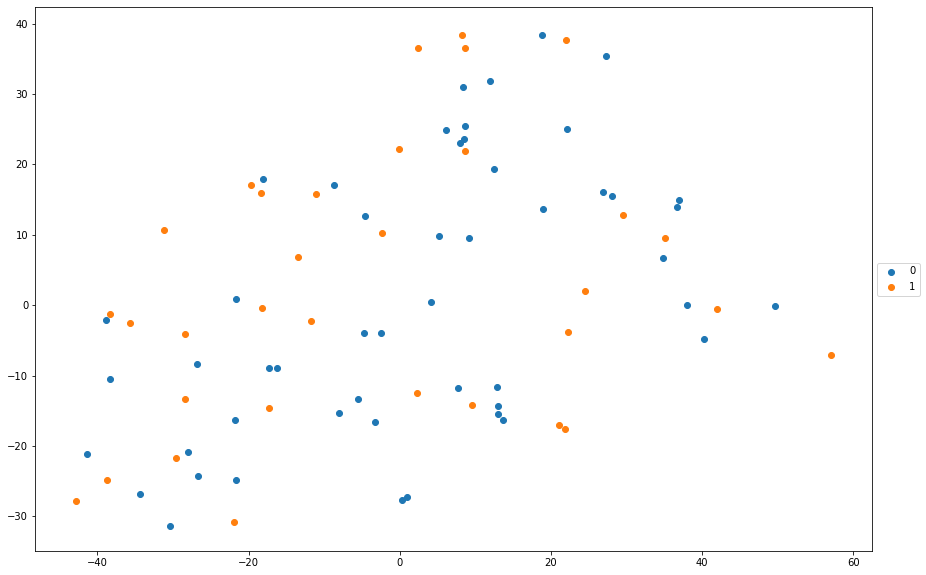

In [195]:
plt.figure(figsize=(15,10))
for c in [0,1]:#set_labels
    indices = np.where(np.array(labels) == c)[0]
    plt.scatter(eval_embedding[indices,0], eval_embedding[indices,1], label=str(c))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

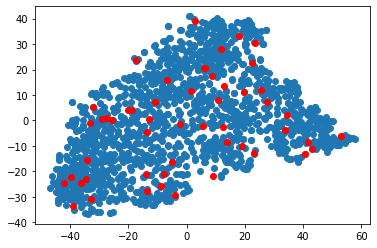

In [194]:
plt.scatter(eval_embedding[:,0], eval_embedding[:,1])
plt.scatter(X_embedded[:52,0], X_embedded[:52,1], color='red')

In [ ]:
def get_true_labels(split, mode, dict_clips=None,video=False):
    if mode == 'prod':
        return None

    #print(f"Path for feather {self.all_train_labels_path}")
    if split == 'train':
        df = pd.read_feather(all_train_labels_path)
    else:
        df = pd.read_feather(test_labels_path)

    # convert string labels to int labels
    mapped_label_col = df['class'].map(label_map)
    df['class'] = mapped_label_col
    #log.info(f"Dataframe: {df.head()}")
    #log.info(f"Label map: {self.label_map}")
    # turn Dataframe into a dict
    df = df.set_index('video_id')
    labels_dict = df.to_dict()['class']
    #log.info(f"Label dict: {labels_dict}")

    # get a list of corresponding labels
    if split == 'train':
        image_names = get_unlabeled_image_names(dictionary_clips=dict_clips, video=video)
    else:
        image_names = get_evaluation_image_names(video=video)

    #log.info(f"Images names:{image_names}")
    labels = [labels_dict[image_name] for image_name in image_names]
    return labels

In [118]:
df = pd.read_feather(test_labels_path)
mapped_label_col = df['class'].map(label_map)
df['class'] = mapped_label_col
df = df.set_index('video_id')
labels_dict = df.to_dict()['class']

In [119]:
# Evaluation set Ground truth
true_names = list(df.index)
labels = [labels_dict[true_name] for true_name in true_names]

# Train SVC

In [120]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import normalize

In [133]:
# Random predictions
rnd_predictions = random.choices(range(len(classes)), 
                                 [1/len(classes)]*len(classes), 
                                 k=len(labels))

preds_valid = rnd_predictions
eval_Y = labels
labs_valid = eval_Y

print((np.array(labs_valid) == np.array(preds_valid)).mean())

0.026587887740029542


### Model train and prediction (here is the same model JPL uses https://gitlab.lollllz.com/bjohnson/lwll_baselines/-/blob/master/video_classification/tools/shallow_model.py lines 67-72)

In [134]:
nembs_train = normalize(X, axis=1)
labs_train = Y
nembs_valid = normalize(eval_X, axis=1)
labs_valid = eval_Y

model       = LinearSVC().fit(nembs_train, labs_train)
preds_valid = model.predict(nembs_valid)
acc_valid   = (labs_valid == preds_valid).mean()
print(acc_valid)

0.02141802067946824
